# Is the SAT unfair? Exploring and visualizing the data to find out

### Goal of this project  

We are going to explore SAT results and NYC high school data to examine if the SAT is unfair to any particular groups of students.


### Approach


### Summary of results

# Introduction to the data

The data file `"nyc_hs_data_clean.csv"`, located in the `"data/processed"` folder of this project, was produced by running the [cleaning-nyc-hs-data](https://github.com/JustinToribio/cleaning-nyc-hs-data) project, which can also be found in this GitHub repository.  We will read the csv file into a dataframe named `data` and view the first 5 rows.

There are 362 rows (1 for each school) and 79 columns in `data`, which contains NYC SAT results by school for the graduating seniors of 2012 in the first few columns.  At the time of this writing, this was the most recent SAT data available.  The remaining columns contain graduation, AP (advanced placement), class size, demographic, school survey and location data for the same school year (or as close to it as possible if the 2012 data was not available).

In [1]:
# Import pandas module and set maximum viewable columns and rows to 500.
import pandas as pd
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 500

# Read csv file into a dataframe named "data" and view the first 5 rows.
data = pd.read_csv("../data/processed/nyc_hs_data_clean.csv")
data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,78.0,43.0,55.1,36.0,46.2,83.7,0.0,0.0,0.0,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1,18.096134,19.175354,13.554735,88.000000,4.000000,22.564286,18.500000,26.571429,88.6,422.0,94.0,22.3,105.0,24.9,34.0,35.0,59.0,14.0,123.0,29.1,227.0,53.8,7.0,1.7,259.0,61.4,163.0,38.6,89.0,70.0,39.0,379.000000,26.0,151.0,6.00000,6.3,7.8,6.7,6.100000,6.1,7.4,6.6,6.700000,6.5,7.6,7.0,5.600000,5.3,7.7,6.2,40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,124.0,53.0,42.7,42.0,33.9,79.2,8.0,6.5,15.1,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1,37.000000,53.000000,21.000000,105.687500,4.750000,22.231250,18.250000,27.062500,71.8,394.0,83.0,21.1,86.0,21.8,55.0,10.0,115.0,29.2,89.0,22.6,181.0,45.9,9.0,2.3,226.0,57.4,168.0,42.6,84.0,95.0,10.0,385.000000,37.0,46.0,6.00000,6.6,7.9,6.8,6.300000,6.6,7.2,6.7,7.000000,7.3,7.3,7.2,5.700000,5.8,7.4,6.3,40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,90.0,70.0,77.8,67.0,74.4,95.7,0.0,0.0,0.0,67.0,74.4,95.7,3.0,3.3,4.3,15.0,16.7,5.0,5.6,12.000000,12.000000,20.562084,57.600000,2.733333,21.200000,19.400000,22.866667,71.8,598.0,30.0,5.0,158.0,26.4,91.0,19.0,58.0,9.7,143.0,23.9,331.0,55.4,62.0,10.4,327.0,54.7,271.0,45.3,0.0,98.0,28.0,422.207196,42.0,150.0,6.79888,7.3,8.7,7.9,6.832925,8.0,8.1,7.9,7.594217,8.8,8.4,8.4,6.151669,8.0,8.2,7.9,40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,84.0,47.0,56.0,40.0,47.6,85.1,17.0,20.2,36.2,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0,14.000000,15.000000,13.779655,69.642857,3.000000,23.571429,20.000000,27.357143,80.7,367.0,41.0,11.2,95.0,25.9,28.0,36.0,34.0,9.3,116.0,31.6,209.0,56.9,6.0,1.6,170.0,46.3,197.0,53.7,90.0,100.0,21.0,306.000000,29.0,69.0,6.40000,6.4,7.7,6.9,6.400000,6.1,7.2,6.6,7.000000,6.8,7.3,7.0,5.900000,5.3,7.4,6.2,40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159.0,522.0,574.0,525.0,1621.0,46.0,46.0,100.0,46.0,100.0,100.0,31.0,67.4,67.4,15.0,32.6,32.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.000000,587.000000,323.000000,156.368421,6.157895,25.510526,19.473684,31.210526,23.0,1613.0,4.0,0.2,43.0,2.7,2.0,0.0,448.0,27.8,189.0,11.7,229.0,14.2,725.0,44.9,794.0,49.2,819.0,50.8,98.0,68.0,51.0,923.000000,67.0,736.0,7.30000,7.6,8.5,7.8,7.000000,5.9,7.9,6.9,7.700000,7.3,8.4,7.8,6.400000,5.6,7.9,6.7,40.718725,-73.979426,1


# The SAT may be geographically biased - mapping SAT scores  

We will begin by creating a color-mapped scatter plot of mean SAT scores, by school district, on a map of NYC.  This will give us a good visualization of any geographic patterns in SAT scores that we can explore further.  

We are plotting the data by school district because plotting each individual school will make the map too cluttered and it will not convey any useful insights.  To group the data by school district we will take the mean of the latitudes, longitudes and SAT scores of all of the schools in a district.  

### Creating the mapping function

First we will create a function named `create_nyc_map` that will allow us to generate the map with different color-mapped sets of data and customizations.  We will also be able to use the function to create 2 side by side maps plotting different sets of data.  In future sections, this will allow us to compare the geographic patterns between the sets of data visually.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeat


def create_nyc_map(column_name_1, column_name_2=None, title=None, 
                   title_y_adj=0.0, subtitle=None, subtitle_y_adj=0.0,
                   sig_space_adj=0, map_title_1=None, map_title_2=None,
                   colorbar_ticks_1=None, colorbar_tick_labels_1=None, 
                   colorbar_ticks_2=None, colorbar_tick_labels_2=None):
    """
    Create color-mapped scatter plots (single map or two side by side 
    maps) of school districts on a map of NYC.
    
    Arguments:
    column_name_1 -- (Str) The column name from "data" to derive the 
                     first (left) scatter plot map from.
    column_name_2 -- (Str, default None) The column name from "data" to 
                     derive the second (right) scatter plot map from. If
                     None, only a map of "column_name_1" will be
                     plotted.
    title -- (Str, default None) The title of the entire plot.
    title_y_adj -- (Float, + or -, default 0.0) The amount of vertical
                   adjustment to the default position of the title, in
                   units of latitude.
    subtitle -- (Str, default None) The subtitle of the entire plot.
    subtitle_y_adj -- (Float, + or -, default 0.0) The amount of
                      vertical adjustment to the default position of the 
                      subtitle, in units of latitude.
    sig_space_adj -- (Int, + only, default 0) The amount of horizontal 
                     character space to add to the right end of the 
                     signature bar.
    map_title_1 -- (Str, default None) The title of the first (left)
                   scatter plot map. "column_name_2" must not be None.
    map_title_2 -- (Str, default None) The title of the second (right)
                   scatter plot map. "column_name_2" must not be None.
    colorbar_ticks_1 -- (List of int or float, default None) Numeric 
                        tick labels for the first (left) map's color-bar
                        legend. If None, ticks are determined
                        automatically from the input.
    colorbar_tick_labels_1 -- (List of int, float or str, default None) 
                              Custom tick labels for the first (left)
                              map's color-bar legend. The 
                              "colorbar_ticks_1" arg must be defined 
                              with a list of numeric values of at least 
                              the same length. I.e. for custom tick 
                              labels of ["10m", "20m", "30m"], 
                              "colorbar_ticks_1" must be defined with
                              [10, 20, 30] at least.
    colorbar_ticks_2 -- (List of int or float, default None) Same as
                        "colorbar_ticks_1" but for the second (right) 
                        map's color-bar legend. "column_name_2" must not
                        be None.
    colorbar_tick_labels_2 -- (List of int, float or str, default None)
                              Same as "colorbar_tick_labels_1" but for 
                              the second (right) map's color-bar legend.
                              The "colorbar_ticks_2" arg must be defined
                              with a list of numeric values of at 
                              least the same length. "column_name_2" 
                              must not be None.
    
    Returns:
    The figure object of the entire plot.
    """

    # Group the data by school district and assign the map data to
    # variables.
    districts = data.groupby("school_dist").agg(np.mean)
    districts.reset_index(inplace=True)
    longitudes = districts["lon"].tolist()
    latitudes = districts["lat"].tolist()
    nyc_boundaries = [-74.255735, -73.700272, 40.496044, 40.915256]
    state_borders = cfeat.NaturalEarthFeature(name="admin_1_states_provinces",
                                              scale="10m", category="cultural")
    signature = ("   ©Justin Toribio"
                 + " "*(2 + sig_space_adj)
                 + "Source: NYC OpenData   ")
    
    # Define the style and plotting parameters for a single map plot
    # and side by side comparison map plot.
    plt.close("all")
    style.use("fivethirtyeight")    
    if column_name_2 is None:
        second_axes = False
        figure_size = (6.5, 6.5)
        axes_1_size = [0, 0, .95, 1]
        colorbar_axes_1_size = [1, .14, .06, .72]
        title_size = 22
        subtitle_size = 16
        signature_size = 14
        signature_x_value = -74.275
    else:
        second_axes = True
        figure_size = (14, 7)
        axes_1_size = [0, 0, .43, 1]
        axes_2_size = [.55, 0, .43, 1]
        colorbar_axes_1_size = [.45, .17, .03, .66]        
        colorbar_axes_2_size = [1, .17, .03, .66]
        title_size = 25
        subtitle_size = 19
        signature_size = 16
        signature_x_value = -74.28
        
    # Create the first (left) map with scatter plot of school districts 
    # and color-bar legend.
    fig = plt.figure(figsize=figure_size)
    ax1 = fig.add_axes(axes_1_size, projection=ccrs.PlateCarree())
    ax1.background_patch.set_facecolor("lightblue")
    ax1.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
    ax1.set_extent(nyc_boundaries)
    districts_plot_1 = ax1.scatter(longitudes, latitudes, s=50, zorder=2,
                                   cmap="Reds", c=districts[column_name_1])
    colorbar_axes_1 = fig.add_axes(colorbar_axes_1_size) 
    colorbar_1 = plt.colorbar(districts_plot_1, cax=colorbar_axes_1,
                              ticks=colorbar_ticks_1)
    if (colorbar_ticks_1 is None) or (colorbar_tick_labels_1 is None):
        pass
    else:
        colorbar_1.ax.set_yticklabels(colorbar_tick_labels_1)

    # Add the title, subtitle, signature and all of the text to the
    # first (left) map.
    ax1.text(s=title, x=-74.255735, y=41.02+title_y_adj, fontsize=title_size,
             weight="bold", alpha=.75)
    ax1.text(s=subtitle, x=-74.255735, y=40.93+subtitle_y_adj, 
             fontsize=subtitle_size, alpha=.85)
    ax1.text(s=signature, x=signature_x_value, y=40.466, 
             fontsize=signature_size, color="#f0f0f0", backgroundcolor="grey")
    ax1.text(s="Bronx", x=-73.89, y=40.85, color="black", alpha=.8,
             weight="bold", rotation=0)
    ax1.text(s="Manhattan", x=-74.02, y=40.835, color="black", alpha=.8,
             weight="bold", rotation=55)
    ax1.text(s="Brooklyn", x=-74.013, y=40.644, color="black", alpha=.8,
             weight="bold", rotation=-10)
    ax1.text(s="Queens", x=-73.9, y=40.74, color="black", alpha=.8,
             weight="bold", rotation=-30)
    ax1.text(s="Staten Island", x=-74.2, y=40.59, color="black", alpha=.8,
             weight="bold", rotation=32)

    # Draw the boundary between Brooklyn and Queens on the first (left)
    # map.
    ax1.plot([-73.954010, -73.889662], [40.737324, 40.684499],
             color="black", linewidth=2, linestyle="dotted")
    ax1.plot([-73.889662, -73.868921], [40.684499, 40.695223],
             color="black", linewidth=2, linestyle="dotted")
    ax1.plot([-73.868921, -73.855090], [40.695223, 40.642811],
             color="black", linewidth=2, linestyle="dotted")    
    
    # If a second column name is defined, create the second (right) map 
    # with scatter plot of school districts and color-bar legend.
    if second_axes:
        ax2 = fig.add_axes(axes_2_size, projection=ccrs.PlateCarree())
        ax2.background_patch.set_facecolor("lightblue")
        ax2.add_feature(state_borders, edgecolor="black",
                        facecolor="lightgrey")
        ax2.set_extent(nyc_boundaries)
        districts_plot_2 = ax2.scatter(longitudes, latitudes, s=50, zorder=2,
                                       cmap="Reds", c=districts[column_name_2])
        colorbar_axes_2 = fig.add_axes(colorbar_axes_2_size) 
        colorbar_2 = plt.colorbar(districts_plot_2, cax=colorbar_axes_2,
                                  ticks=colorbar_ticks_2)
        if (colorbar_ticks_2 is None) or (colorbar_tick_labels_2 is None):
            pass
        else:
            colorbar_2.ax.set_yticklabels(colorbar_tick_labels_2)

        # Add the individual map titles and all of the text to the
        # second (right) map.
        ax1.text(s=map_title_1, x=-74.255735, y=40.925, weight="bold",
                 fontsize=subtitle_size-1, alpha=.75)
        ax2.text(s=map_title_2, x=-74.255735, y=40.925, weight="bold",
                 fontsize=subtitle_size-1, alpha=.75)
        ax2.text(s="Bronx", x=-73.89, y=40.85, color="black", alpha=.8,
                 weight="bold", rotation=0)
        ax2.text(s="Manhattan", x=-74.02, y=40.835, color="black", alpha=.8,
                 weight="bold", rotation=55)
        ax2.text(s="Brooklyn", x=-74.013, y=40.644, color="black", alpha=.8,
                 weight="bold", rotation=-10)
        ax2.text(s="Queens", x=-73.9, y=40.74, color="black", alpha=.8,
                 weight="bold", rotation=-30)
        ax2.text(s="Staten Island", x=-74.2, y=40.59, color="black", alpha=.8,
                 weight="bold", rotation=32)

        # Draw the boundary between Brooklyn and Queens on the second 
        # (right) map.
        ax2.plot([-73.954010, -73.889662], [40.737324, 40.684499],
                 color="black", linewidth=2, linestyle="dotted")
        ax2.plot([-73.889662, -73.868921], [40.684499, 40.695223],
                 color="black", linewidth=2, linestyle="dotted")
        ax2.plot([-73.868921, -73.855090], [40.695223, 40.642811],
                 color="black", linewidth=2, linestyle="dotted")        
    else:
        pass    
    plt.close("all")
        
    return fig

### Creating and displaying the map plot

Next we will call on the `create_nyc_map` function to create and display the map plot of SAT scores.

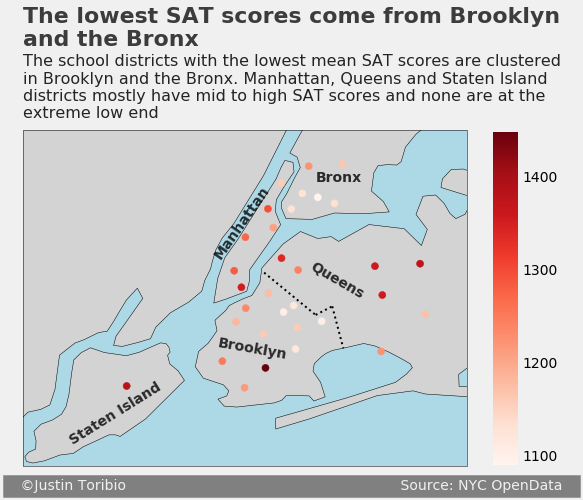

In [3]:
# Assign the title and subtitle of the map plot to variables.
title = ("The lowest SAT scores come from Brooklyn\n"
         "and the Bronx")
subtitle = (
    "The school districts with the lowest mean SAT scores are clustered\n"
    "in Brooklyn and the Bronx. Manhattan, Queens and Staten Island\n"
    "districts mostly have mid to high SAT scores and none are at the\n"
    "extreme low end"
)

# Create and display the map plot of SAT scores.
create_nyc_map("sat_score", title=title, subtitle=subtitle, sig_space_adj=59,
               colorbar_ticks_1=[1100, 1200, 1300, 1400])

In the map above, each dot represents 1 of the 32 school districts across the 5 boroughs of NYC.  The color of each dot is a shade of red, which represents the mean SAT score across all of the schools in that district.  Referring to the color-bar legend to the right of the map, lighter and darker red dots represent lower and higher mean SAT scores, respectively.  

The school districts with the lowest mean SAT scores are clustered in Brooklyn and the Bronx.  With the exception of 1 district in Brooklyn, which actually has the highest mean SAT score (the darkest red dot), all of the other districts in these 2 boroughs score on the low end of the range.  They are also the only boroughs with districts that score on the extreme low end (the nearly white dots).  

The majority of districts in Manhattan, Queens and Staten Island score on the mid to high end of the range and none are at the extreme low end.  

This suggests there is potentially some geographic bias in the SAT, which could be associated with any number of factors: demographic, socio-economic, educational standards and environment etc...  We will attempt to uncover the nature of any potential bias in the rest of this project.

# Finding the nature of any bias in the SAT  

To begin finding the nature of any potential bias in the SAT, we will determine which columns in the data are most strongly correlated with SAT scores.  We will do this by viewing a horizontal bar plot of Pearson correlation coefficients between each column and the `"sat_score"` column in `data`.  

The Pearson correlation coefficient measures the strength and direction of a linear relationship between two quantitative variables.  The maximum possible value is +1, indicating a perfect positive linear relationship (as one variable increases, the other variable *increases* in linear proportion).  The minimum possible value is –1, indicating a perfect negative linear relationship (as one variable increases, the other variable *decreases* in linear proportion).  A coefficient of 0 indicates no linear relationship between the two variables.  

Correlation does not necessarily indicate *causality* (that an increase in one variable *causes* an increase or decrease in the other variable).   It is only an indication of the strength and direction of a linear relationship between two variables.  

### Creating the correlation bar plot function  

First we will create a function named `corr_bar_plot` that will allow us to generate the correlation bar plot with different filters and customizations easily.

In [4]:
import operator

def corr_bar_plot(df, target, columns=None, drop_cols=None, criteria=None,
                  threshold=0, fig_size=(7, 7), x_axis_label=None,
                  title=None, title_x_adj=0, title_y_adj=0, title_size_adj=0,
                  sub=None, sub_x_adj=0, sub_y_adj=0, sub_size_adj=0,
                  sig_space_adj=0, sig_x_adj=0, sig_y_adj=0, sig_size_adj=0):
    """
    Create a horizontal bar plot of Pearson correlation coefficients
    between the columns in a DataFrame and a target column.
    
    Arguments:
    df -- (DataFrame) The input data.
    target -- (Str) The target column label in "df". The correlations of
              all of the other columns will be calculated with respect
              to this column.
    columns -- (List of str, default None) The column labels from "df"
               to display in the plot. If None, all of the columns will
               be displayed.
    drop_cols -- (List of str, default None) The column labels from "df"
                 to remove from the plot.
    criteria -- (Str, default None) The comparison operator used to
                filter the columns displayed in the plot with respect to
                the "threshold" parameter. Can be the following values:
                    ">": greater than "threshold"
                    ">=": greater than or equal to "threshold"
                    "<": less than "threshold"
                    "<=": less than or equal to "threshold"
                    "=": equal to "threshold"
                    "abs": greater than or equal to the absolute value
                           of "threshold"
    threshold -- (Float, default 0) The numeric cutoff value to filter
                 the columns in the plot by. The "criteria" parameter
                 must not be None.
    fig_size -- (Tuple of floats, default (7, 7)) The (width, height)
                dimensions of the plot.
    x_axis_label -- (Str, default None) The label for the x-axis.
    title -- (Str, default None) The title of the plot.
    title_x_adj -- (Float, + or -, default 0) The amount of horizontal
                   adjustment to the default position of the title.
    title_y_adj -- (Float, + or -, default 0) The amount of vertical
                   adjustment to the default position of the title.
    title_size_adj -- (Float, + or -, default 0) The amount of
                      adjustment to the default font size of the title.
    sub -- (Str, default None) The subtitle of the plot.
    sub_x_adj -- (Float, + or -, default 0) The amount of horizontal
                 adjustment to the default position of the subtitle.
    sub_y_adj -- (Float, + or -, default 0) The amount of vertical
                 adjustment to the default position of the subtitle.
    sub_size_adj -- (Float, + or -, default 0) The amount of adjustment
                    to the default font size of the sub title.
    sub -- (Str, default None) The subtitle of the plot.
    sig_space_adj -- (Int, + only, default 0) The amount of horizontal 
                     character space to add to the right end of the 
                     signature bar.
    sig_x_adj -- (Float, + or -, default 0) The amount of horizontal
                 adjustment to the default position of the signature
                 bar.
    sig_y_adj -- (Float, + or -, default 0) The amount of vertical
                 adjustment to the default position of the signature
                 bar.
    sig_size_adj -- (Float, + or -, default 0) The amount of adjustment
                    to the default font size of the signature bar.
    
    Returns:
    None. The bar plot will be displayed when the function is called
    in a Jupyter Notebook with the "%matplotlib inline" magic.
    """
    
    # Assign the comparison operator dictionary and plot signature to
    # variables.
    operator_dict = {">": operator.gt,
                     "<": operator.lt,
                     ">=": operator.ge,
                     "<=": operator.le,
                     "=": operator.eq}
    signature = ("   ©Justin Toribio"
                 + " "*(2 + sig_space_adj)
                 + "Source: NYC OpenData   ")
    
    # Define the correlation dataset based on the values of the function
    # parameters.
    corr = df.corr()[target]    
    if columns is None:
        pass
    else:
        corr = corr[columns]        
    if drop_cols is None:
        pass
    else:
        corr.drop(drop_cols, inplace=True)    
    if criteria is None:
        pass
    elif criteria == "abs":
        corr = corr[abs(corr) >= threshold]
    else:
        corr = corr[operator_dict[criteria](corr, threshold)]
        
    # Create and display the correlation bar plot.
    plt.close("all")
    style.use("fivethirtyeight")
    graph = corr.plot.barh(figsize=fig_size)
    graph.set_xlabel(x_axis_label, labelpad=13)
    graph.text(s=title, x=title_x_adj, y=5+title_y_adj,
               fontsize=22+title_size_adj, weight="bold", alpha=.75)
    graph.text(s=sub, x=sub_x_adj, y=3+sub_y_adj, fontsize=17+sub_size_adj,
               alpha=.85)
    graph.text(s=signature, x=sig_x_adj, y=-4+sig_y_adj, color="#f0f0f0",
               fontsize=14+sig_size_adj, backgroundcolor="grey")
    
    return None

### Creating and displaying the correlation bar plot  

Next we will call on the `corr_bar_plot` function to create and display the correlation bar plot.  Since we are trying to find evidence of bias in the SAT, we will filter the plot to only show columns with an absolute correlation greater than 0.4 with `"sat_score"`.  We will also filter out any columns pertaining to SAT scores, since that is our target variable.

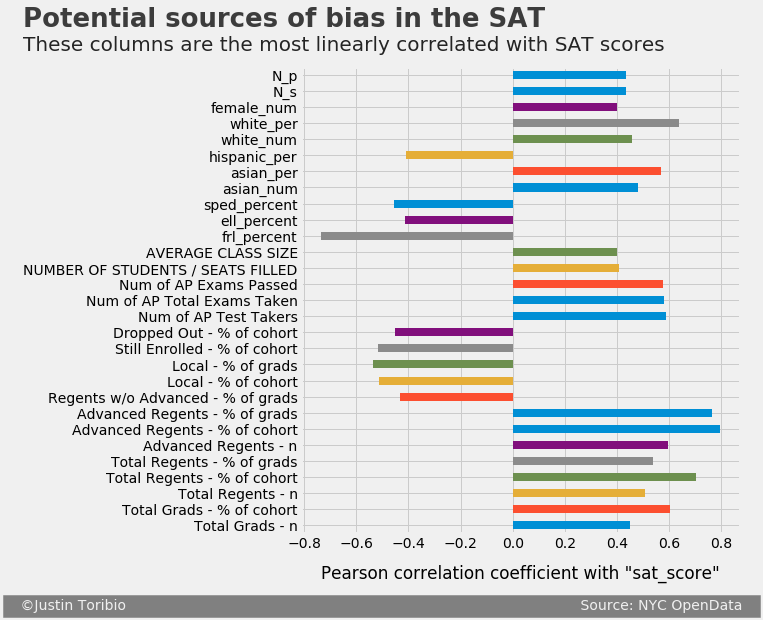

In [5]:
# Assign the list of column names to drop and the text of the bar plot
# to variables.
drop_columns = ["sat_score", "SAT Writing Avg. Score", 
                "SAT Critical Reading Avg. Score", "SAT Math Avg. Score",
                "Num of SAT Test Takers"]
title = "Potential sources of bias in the SAT"
subtitle = "These columns are the most linearly correlated with SAT scores"
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", criteria="abs", threshold=.4, fig_size=(7, 8),
              drop_cols=drop_columns, x_axis_label=x_axis_label,
              title=title, title_x_adj=-1.88, title_y_adj=26, title_size_adj=4,
              sub=subtitle, sub_x_adj=-1.88, sub_y_adj=26.5, sub_size_adj=3,
              sig_x_adj=-1.94, sig_y_adj=-1.25, sig_space_adj=99)

The column names in the bar plot above can be grouped into the following categories of data: survey, demographic, class size, AP (advanced placement) and graduation.  We will explore each category in the following sections.  

# School survey participation may influence SAT scores  

The first 2 column names in the correlation bar plot above (`"N_p"` and `"N_s"`) both pertain to survey data.  We will display the bar plot again showing only these 2 columns.

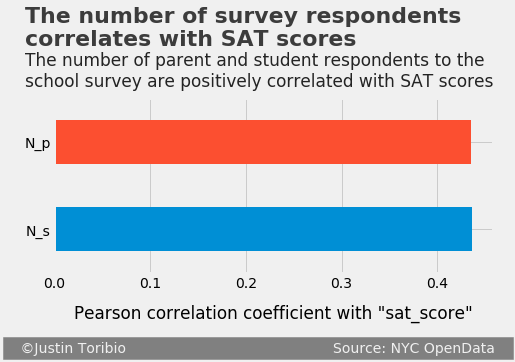

In [6]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["N_s", "N_p"]
title = ("The number of survey respondents\n"
         "correlates with SAT scores")
subtitle = ("The number of parent and student respondents to the\n"
            "school survey are positively correlated with SAT scores\n")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.9, title_x_adj=-.03,
              sub=subtitle, sub_y_adj=-1.6, sub_x_adj=-.03,
              sig_y_adj=2.6, sig_x_adj=-.049, sig_space_adj=44)

`"N_p"` and `"N_s"` are the numbers of parent and student respondents to the school survey, respectively.  Both are positively correlated with SAT scores.  

However, looking at the "number" of respondents may be misleading due to schools having different student population sizes.  We want to look at the response "rates" so that comparisons between schools are commensurate.  The response rates for parents and students are represented by the columns `"rr_p"` and `"rr_s"`, respectively.  We will re-create the correlation bar plot including these 2 columns.

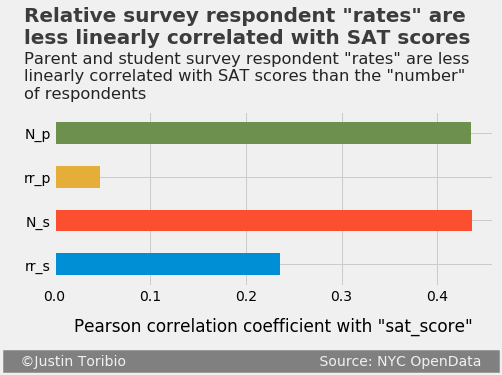

In [7]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["rr_s", "N_s", "rr_p", "N_p"]
title = ('Relative survey respondent "rates" are\n'
         'less linearly correlated with SAT scores')
subtitle = ('Parent and student survey respondent "rates" are less\n'
            'linearly correlated with SAT scores than the "number"\n'
            'of respondents')
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns, fig_size=(7, 3),
              x_axis_label=x_axis_label, title=title,
              title_y_adj=.05, title_x_adj=-.031, title_size_adj=-2,
              sub=subtitle, sub_y_adj=.8, sub_x_adj=-.031, sub_size_adj=-.7,
              sig_y_adj=1.7, sig_x_adj=-.049, sig_space_adj=41)

The parent and student survey respondent "rates" are significantly less linearly correlated with SAT scores than the corresponding "number" of respondents.  The correlation coefficients of both rates are below the initial 0.4 threshold that we set.

Next, we will look at scatter plots of the parent and student respondent rates against SAT scores to see if there's any evidence of non-linear relationships between these 2 variables and SAT results.

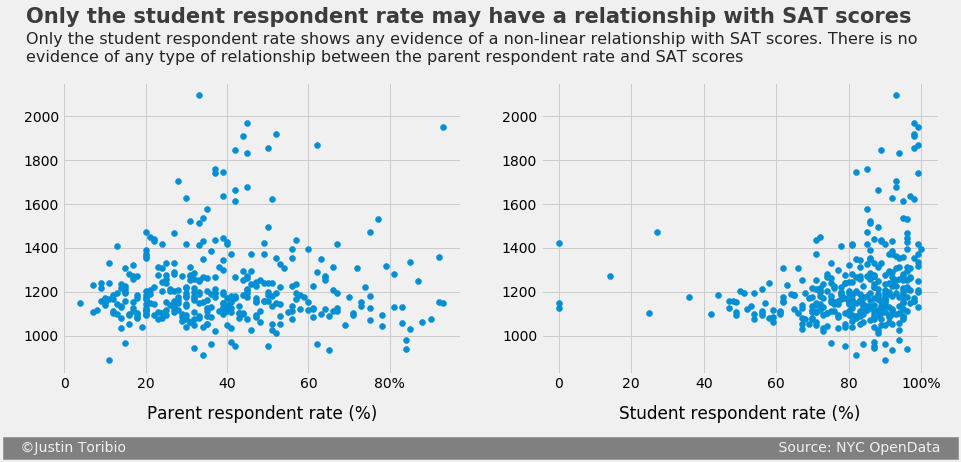

In [8]:
# Assign the text of the scatter plots to variables.
title = ("Only the student respondent rate may have a relationship with SAT"
         " scores")
subtitle = ("Only the student respondent rate shows any evidence of a" 
            " non-linear relationship with SAT scores. There is no\n" 
            "evidence of any type of relationship between the"
            " parent respondent rate and SAT scores")
x_axis_label_1 = "Parent respondent rate (%)"
x_axis_label_2 = "Student respondent rate (%)"
signature = ("   ©Justin Toribio"
             + " "*145
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["rr_p"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-9.5, y=2425, fontsize=21, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-9.5, y=2250, fontsize=16, alpha=.85)
ax1.text(s=signature, x=-14, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["rr_s"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

There is no evidence of any type of relationship between the parent respondent rate and SAT scores.  There is some evidence of a non-linear relationship between the student respondent rate and SAT scores.  The only schools with mean SAT scores above 1500 have a student respondent rate above 80%.  All schools with a student respondent rate 80% or below have mean SAT scores below 1500.

This does not mean that all schools with high student respondent rates will necessarily have high SAT scores.  Likewise, having low SAT scores does not necessarily mean having low student respondent rates.  The only statement we can make is: if a school has a really high mean SAT score, it probably has a very high student respondent rate on the school survey.  If a school has a really low student respondent rate, it probably does not have a high mean SAT score.  

This makes intuitive sense.  Schools with high mean SAT scores are likely to have more students that take the quality of their education seriously, and thus are more willing to be active in their schools' improvement by participating in the survey.  In contrast, schools with lower student respondent rates may indicate the students lack engagement and interest with the quality of their education, which could also translate to poorer SAT preparation.  

# Exploring demographic data and SAT scores  

The 3rd through 11th column names in the initial correlation bar plot above (`"female_num"` to `"frl_percent"`) all pertain to demographic data.  We will display the bar plot again showing only these columns.

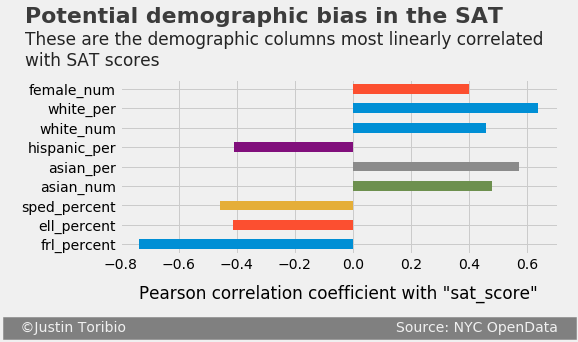

In [9]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["frl_percent", "ell_percent", "sped_percent", "asian_num",
           "asian_per", "hispanic_per", "white_num", "white_per", "female_num"]
title = "Potential demographic bias in the SAT"
subtitle = ("These are the demographic columns most linearly correlated\n"
            "with SAT scores")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=6.4, title_x_adj=-1.13,
              sub=subtitle, sub_y_adj=6.2, sub_x_adj=-1.13,
              sig_y_adj=-.5, sig_x_adj=-1.19, sig_space_adj=58)

The column names in the bar plot above can be grouped into the following categories of demographic data: Female, White, Hispanic, Asian, Special Education, English Language Learner, and Free or Reduced Price Lunch.  

We will ignore the Special Education data (`"sped_percent"`), which is negatively correlated with SAT scores.  Special Education is a form of learning provided to students with exceptional needs, such as students with learning disabilities or mental challenges.  It is a reasonably intuitive expectation that schools with higher proportions of Special Education students will also have lower mean SAT scores.  So there is not much insight to be gained here.

We will explore the remaining demographic categories in the following sub-sections.  

## More female students may mean higher SAT scores  

The `"female_num"` column represents the total number of female students in the school and has a positive correlation with `"sat_score"` of approximately 0.4.  However, similar to survey respondents, we want to look at the percent of female students to account for differences in school population sizes.  This data is represented in the `"female_per"` column.  

We will re-create the correlation bar plot including only these 2 columns.

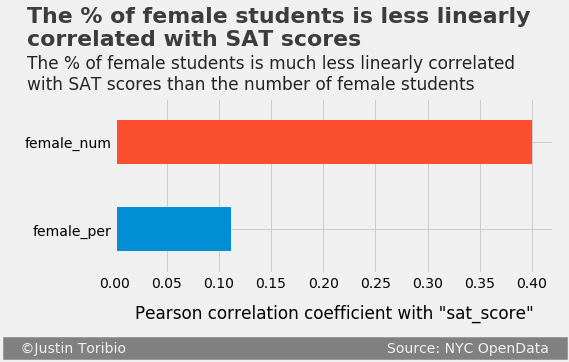

In [10]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["female_per", "female_num"]
title = ("The % of female students is less linearly\n"
         "correlated with SAT scores")
subtitle = ("The % of female students is much less linearly correlated\n"
            "with SAT scores than the number of female students")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.9, title_x_adj=-.084,
              sub=subtitle, sub_y_adj=-1.4, sub_x_adj=-.084,
              sig_y_adj=2.6, sig_x_adj=-.103, sig_space_adj=56)

The % of female students is significantly less linearly correlated with SAT scores than the number of female students.  Next, we will look at a scatter plot of the % of female students against SAT scores to see if there's any evidence of a non-linear relationship between the 2 variables.

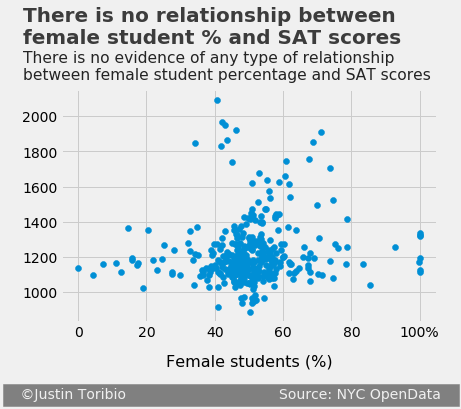

In [11]:
# Assign the text of the scatter plot to variables.
title = ("There is no relationship between\n"
         "female student % and SAT scores")
subtitle = ("There is no evidence of any type of relationship\n"
            "between female student percentage and SAT scores")
x_axis_label_1 = "Female students (%)"
signature = ("   ©Justin Toribio"
             + " "*34
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(6,4))

# Create the scatter plot, add the text and display the plot.
ax1 = fig.add_subplot(111)
ax1.scatter(data["female_per"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14, fontsize=16)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-16, y=2415, fontsize=20, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-16, y=2210, fontsize=15.5, alpha=.85)
ax1.text(s=signature, x=-20.75, y=390, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")
plt.show()

There is no evidence of any type of relationship between female student % and SAT scores.  The only noticeable pattern is that all schools with a heavy concentration in either sex (greater than 80% female or less than 30% female, which means a male concentration greater than 70%) have mean SAT scores below 1400. This suggests there could be a connection between sexual diversity in a school and SAT performance.

## English Language Learners and Free or Reduced Price Lunches may explain SAT racial bias  

Looking at the correlation bar plot, it appears there could be some racial bias in the SAT in favor of White and Asian students, and against Hispanic students.  However, the `"ell_percent"` (% of students that are English Language Learners) and `"frl_percent"` (% of students that receive free or reduced price lunches) columns are particularly interesting.  You can draw very logical connections between these factors and SAT performance, and they could also explain the potential racial bias we see.  

English Language Learners would be expected to have difficulty on a test written in English, such as the SAT.  [Students are eligible to receive free or reduced price lunches if their families' incomes are close enough to the established poverty line](https://otda.ny.gov/workingfamilies/schoollunch.asp).  Students receiving free or reduced price lunches means they are from low-income families, which likely means they have less access to academic resources (i.e. tutors, computers, school supplies etc...).  Schools with a high % of students from low-income families could mean they are located in low-income neighborhoods, which may lack the necessary financial funding and resources to support high quality education standards.  All of these factors would naturally lead to poorer SAT performance.

We will view the scatter plots of `"ell_percent"` and `"frl_percent"` against `"sat_score"` to get a visual representation of their relationships.

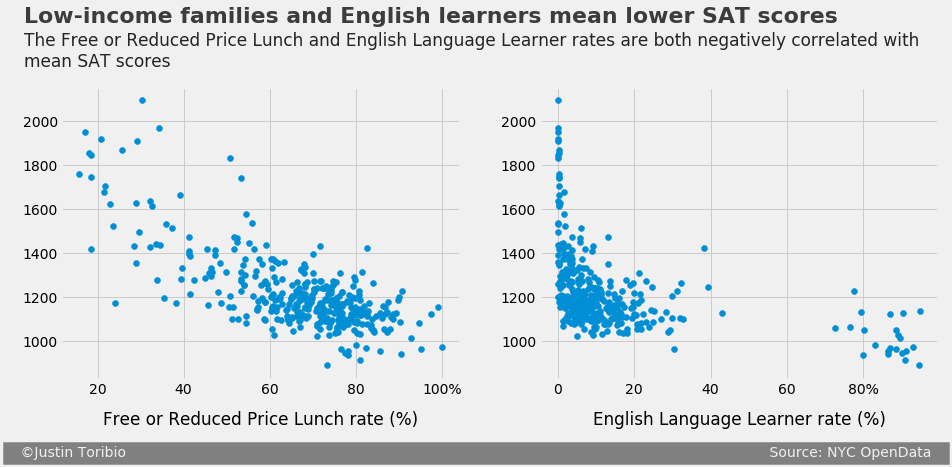

In [12]:
# Assign the text of the scatter plots to variables.
title = "Low-income families and English learners mean lower SAT scores"
subtitle = ("The Free or Reduced Price Lunch and English Language Learner"
            " rates are both negatively correlated with\n"
            "mean SAT scores")
x_axis_label_1 = "Free or Reduced Price Lunch rate (%)"
x_axis_label_2 = "English Language Learner rate (%)"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["frl_percent"], data["sat_score"])
ax1.set_xticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=3, y=2450, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=3, y=2250, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-1, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["ell_percent"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

The Free or Reduced Price Lunch (herein referred to as "FRL") and English Language Learner (herein referred to as "ELL") rates are both negatively correlated with mean SAT scores.  

The FRL rate has a stronger negative linear correlation (approximately -0.7).  There is a very clear downward linear trend in mean SAT scores as FRL rates increase.  All schools with an FRL rate above 59% have mean SAT scores below 1500.  The only schools with mean SAT scores above 1500 have FRL rates below 59%.  This is consistent with our hypothesis about the relationship between these 2 variables in the section above.  

The ELL rate has a weaker negative linear correlation (approximately -0.41).  There is more of a non-linear negative relationship between the 2 variables.  Most of the schools are clustered in an ELL rate range of 0 to 30%.  All schools with an ELL rate above 10% have mean SAT scores below 1500.  The only schools with mean SAT scores above 1600 have ELL rates at or close to 0%.  This is consistent with our hypothesis about the relationship between these 2 variables in the section above.  

Next, we will view the scatter plots of the 3 racial columns against `"sat_score"` to get a visual representation of their relationships.

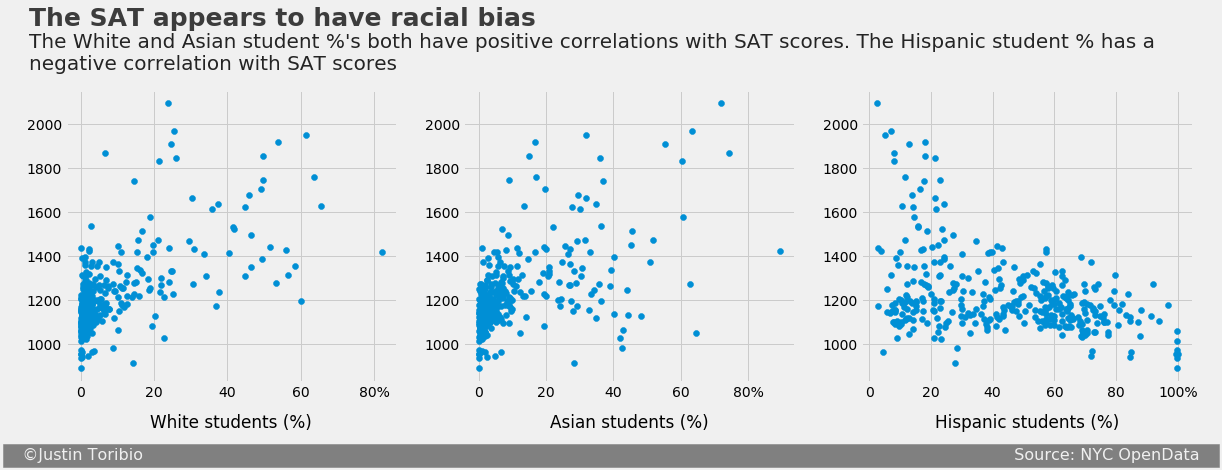

In [13]:
# Assign the text of the scatter plots to variables.
title = "The SAT appears to have racial bias"
subtitle = ("The White and Asian student %'s both have positive correlations"
            " with SAT scores. The Hispanic student % has a\n"
            "negative correlation with SAT scores")
x_axis_label_1 = "White students (%)"
x_axis_label_2 = "Asian students (%)"
x_axis_label_3 = "Hispanic students (%)"
signature = ("   ©Justin Toribio"
             + " "*170
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(18,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(131)
ax1.scatter(data["white_per"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-14, y=2450, fontsize=25, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-14, y=2250, fontsize=20, alpha=.85)
ax1.text(s=signature, x=-20, y=470, fontsize=16, color="#f0f0f0",
         backgroundcolor="grey")

# Create the middle scatter plot.
ax2 = fig.add_subplot(132)
ax2.scatter(data["asian_per"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)

# Create the right scatter plot and display the entire plot.
ax3 = fig.add_subplot(133)
ax3.scatter(data["hispanic_per"], data["sat_score"])
ax3.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax3.set_xlabel(x_axis_label_3, labelpad=14)
ax3.yaxis.label.set_visible(False)
plt.show()

At first glance, it appears there is some racial bias in the SAT.  Although the visual relationships don't appear to be that strong, there is definitely an upward trend between the White and Asian student percentages and SAT scores.  The minimum mean SAT score increases as either the White student percentage or Asian student percentage increases.

In contrast, there is definitely a downward trend between the Hispanic student percentage and SAT scores.  The maximum mean SAT score declines as the Hispanic student percentage increases.  All schools with a Hispanic student percentage greater than 30% have a mean SAT score less than 1500.  The only schools with mean SAT scores greater than 1500 have a Hispanic student percentage less than 30%.  

However, before jumping to the conclusion that the SAT is racially discriminatory, let's explore if there is a relationship between each of the 3 racial groups and our 2 initial demographic variables of interest: FRL (Free or Reduced Price Lunch) and ELL (English Language Learners).  First, we will view the correlation coefficient bar plots between the 3 racial groups and the FRL and ELL rates.

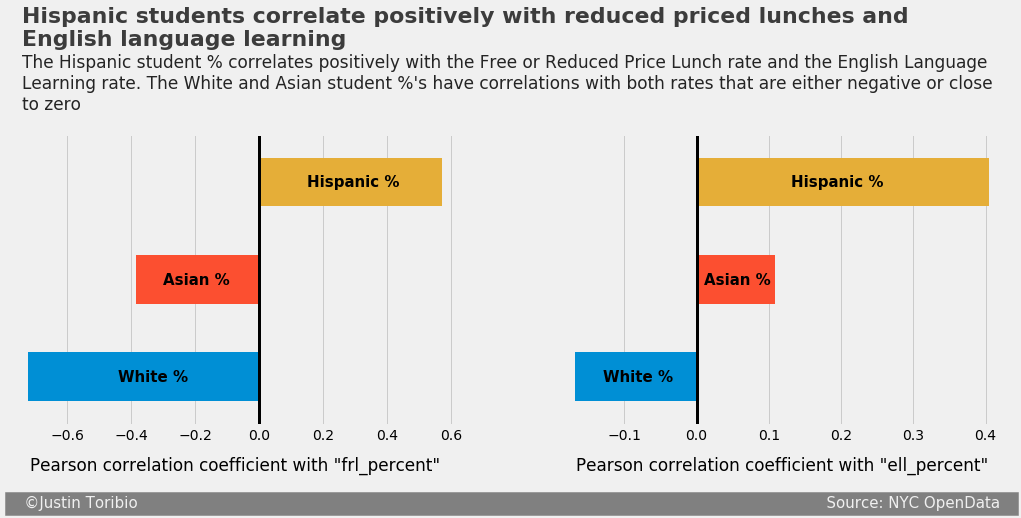

In [14]:
# Assign the text of the bar plots to variables.
title = ("Hispanic students correlate positively with reduced priced"
         " lunches and\n"
         "English language learning")
subtitle = ("The Hispanic student % correlates positively with the Free or"
            " Reduced Price Lunch rate and the English Language\n"
            "Learning rate. The White and Asian student %'s have correlations"
            " with both rates that are either negative or close\n"
            "to zero")
x_axis_label_1 = 'Pearson correlation coefficient with "frl_percent"'
x_axis_label_2 = 'Pearson correlation coefficient with "ell_percent"'
signature = ("   ©Justin Toribio"
             + " "*145
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(16,5))

# Create the left bar plot and add the text of the entire plot.
corr = data.corr()["frl_percent"]
corr = corr[["white_per", "asian_per", "hispanic_per"]]
ax1 = fig.add_subplot(121)
ax1 = corr.plot.barh()
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.get_yaxis().set_visible(False)
ax1.plot([0, 0], [-.5, 3.5], color="black", linewidth=3)
ax1.text(s="Hispanic %", x=0.15, y=1.95, fontsize=15, weight="bold")
ax1.text(s="Asian %", x=-0.3, y=0.95, fontsize=15, weight="bold")
ax1.text(s="White %", x=-0.44, y=-.05, fontsize=15, weight="bold")
ax1.text(s=title, x=-.74, y=3.4, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-.74, y=2.75, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-.78, y=-1.35, fontsize=15, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right bar plot and display the entire plot.
corr = data.corr()["ell_percent"]
corr = corr[["white_per", "asian_per", "hispanic_per"]]
ax2 = fig.add_subplot(122)
ax2 = corr.plot.barh()
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.get_yaxis().set_visible(False)
ax2.plot([0, 0], [-.5, 3.5], color="black", linewidth=3)
ax2.text(s="Hispanic %", x=0.13, y=1.95, fontsize=15, weight="bold")
ax2.text(s="Asian %", x=0.01, y=0.95, fontsize=15, weight="bold")
ax2.text(s="White %", x=-0.13, y=-.05, fontsize=15, weight="bold")
plt.show()

The Hispanic student % correlates positively with both the FRL and ELL rates.  In contrast, the White and Asian student %'s have correlations with both rates that are either negative or close to zero.  This suggests that the apparent racial bias we see in SAT results isn't really tied to any kind of inherent racial discrimination in the test, but rather the propensity for each group to come from low-income households or to be learning the English language.  

Next, we will view the scatter plots between the 3 racial groups and the FRL and ELL rates to get a visual representation of their relationships.

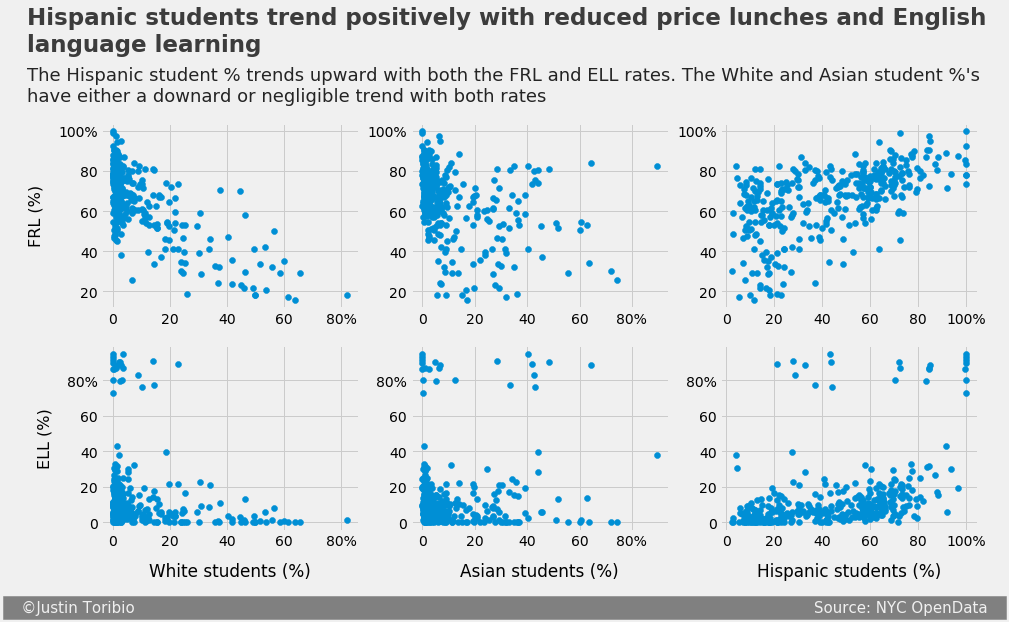

In [15]:
# Assign the text of the scatter plots to variables.
title = ("Hispanic students trend positively with reduced price lunches and"
         " English\n"
         "language learning")
subtitle = ("The Hispanic student % trends upward with both the FRL and ELL"
            " rates. The White and Asian student %'s\n"
            "have either a downard or negligible trend with both rates")
x_axis_label_1 = "White students (%)"
x_axis_label_2 = "Asian students (%)"
x_axis_label_3 = "Hispanic students (%)"
y_axis_label_1 = "FRL (%)"
y_axis_label_2 = "ELL (%)"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,7))

# Create the top left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(231)
ax1.scatter(data["white_per"], data["frl_percent"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_ylabel(y_axis_label_1, labelpad=14, fontsize=16)
ax1.text(s=title, x=-30, y=140, fontsize=23, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-30, y=115, fontsize=18, alpha=.85)
ax1.text(s=signature, x=-37, y=-140, fontsize=15, color="#f0f0f0",
         backgroundcolor="grey")

# Create the top middle scatter plot.
ax2 = fig.add_subplot(232)
ax2.scatter(data["asian_per"], data["frl_percent"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax2.yaxis.label.set_visible(False)

# Create the top right scatter plot.
ax3 = fig.add_subplot(233)
ax3.scatter(data["hispanic_per"], data["frl_percent"])
ax3.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax3.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax3.yaxis.label.set_visible(False)

# Create the bottom left scatter plot.
ax4 = fig.add_subplot(234)
ax4.scatter(data["white_per"], data["ell_percent"])
ax4.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax4.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax4.set_xlabel(x_axis_label_1, labelpad=14)
ax4.set_ylabel(y_axis_label_2, labelpad=14, fontsize=16)

# Create the bottom middle scatter plot.
ax5 = fig.add_subplot(235)
ax5.scatter(data["asian_per"], data["ell_percent"])
ax5.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax5.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax5.set_xlabel(x_axis_label_2, labelpad=14)
ax5.yaxis.label.set_visible(False)

# Create the bottom right scatter plot and display the entire plot.
ax6 = fig.add_subplot(236)
ax6.scatter(data["hispanic_per"], data["ell_percent"])
ax6.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax6.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax6.set_xlabel(x_axis_label_3, labelpad=14)
ax6.yaxis.label.set_visible(False)
plt.show()

The Hispanic student % has a very clear upward trend with the FRL rate (top right plot).  While not as evident or strong, there is also an upward trend with the ELL rate (bottom right plot).  In contrast, the White and Asian student %'s have either downward or negligible trends with both rates.  This further supports our theory that the apparent racial bias in the SAT is actually explained by the FRL and ELL rates.  

Next, we will display the data on maps of NYC again to see if the geographic patterns are consistent with our findings above.  We will also see if we can explain the geographic pattern in SAT results we discovered in one of the initial sections of this project.  We will start by comparing the map of SAT scores with the map of Hispanic student %'s.

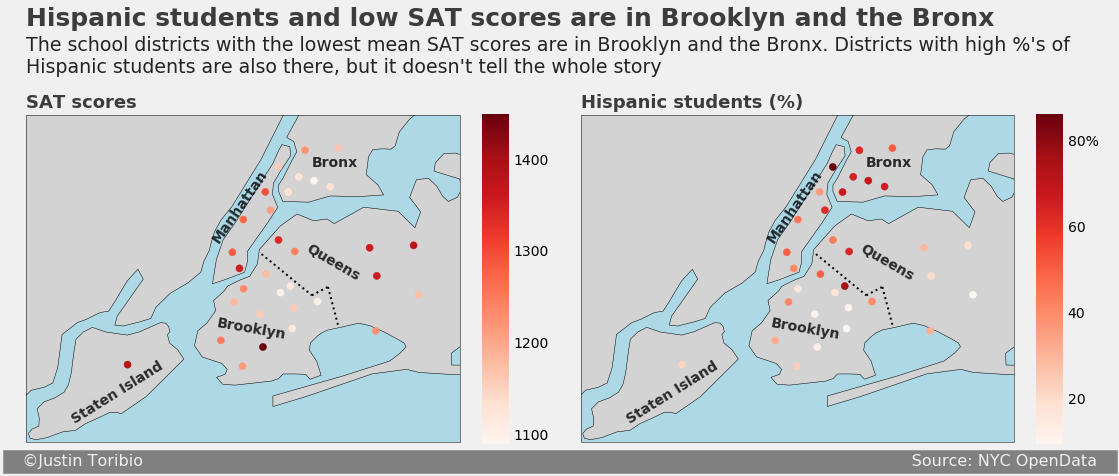

In [16]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students and low SAT scores are in Brooklyn and the Bronx"
subtitle = ("The school districts with the lowest mean SAT scores are in" 
            " Brooklyn and the Bronx. Districts with high %'s of\n"
            "Hispanic students are also there, but it doesn't tell the whole"
            " story")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "hispanic_per", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT scores", 
               map_title_2="Hispanic students (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[20, 40, 60, 80], 
               colorbar_tick_labels_2=[20, 40, 60, "80%"])

As we discovered before, the lowest mean SAT scores come from Brooklyn and the Bronx (left map).  There are also districts with high concentrations of Hispanic students in those boroughs (right map).  However, there are quite a few districts in Brooklyn that have low Hispanic student concentrations as well as low mean SAT scores.  This suggests there is more to the story than simply Hispanic students performing poorly on the SAT or the SAT having a racial bias against Hispanic students.

Next, we will compare the map of SAT scores with the map of FRL (Free or Reduced Price Lunch) rates.

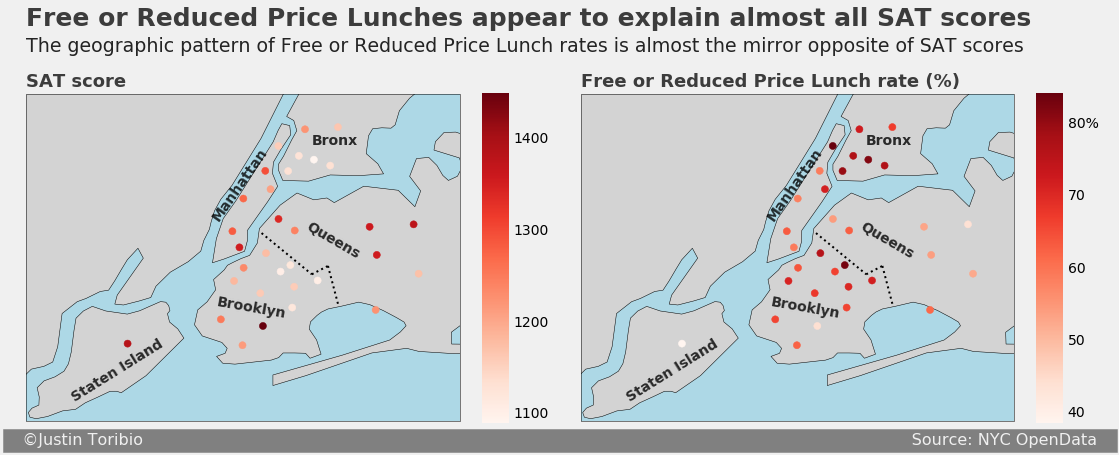

In [17]:
# Assign the title and subtitle of the map plot to variables.
title = ("Free or Reduced Price Lunches appear to explain almost all SAT"
         " scores")
subtitle = ("The geographic pattern of Free or Reduced Price Lunch rates is" 
            " almost the mirror opposite of SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "frl_percent", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT score", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

The FRL (Free or Reduced Price Lunch) rate appears to explain almost all SAT scores.  The 2 maps are almost mirror opposites of each other.  Districts with high FRL rates have low mean SAT scores and those with low FRL rates have high SAT scores.  This is consistent with our theory that high FRL rates are indicative of low-income families and neighborhoods, which would correlate with poor SAT performance due to lack of access to academic resources.  

Next, we will compare the map of Hispanic student %'s with the map of Free or Reduced Price Lunch rates.

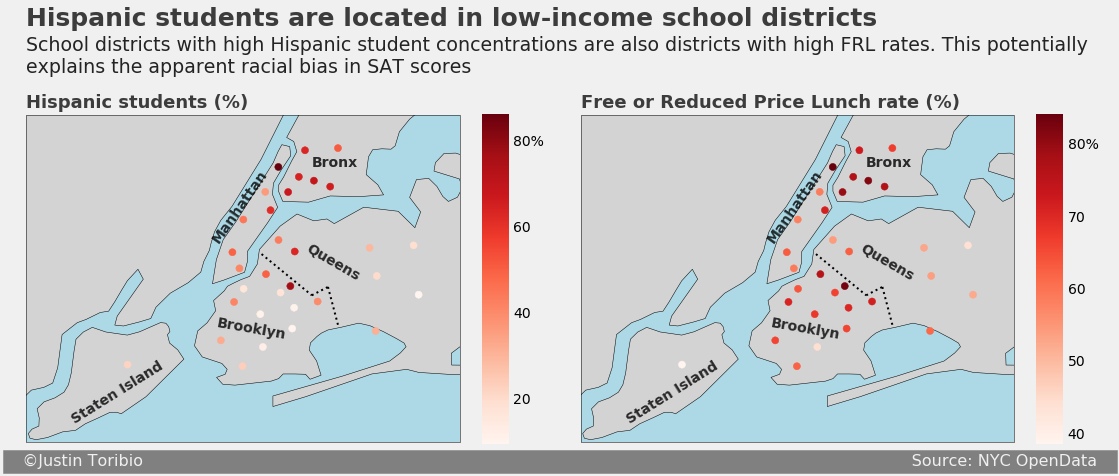

In [18]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students are located in low-income school districts"
subtitle = ("School districts with high Hispanic student concentrations are" 
            " also districts with high FRL rates. This potentially\n"
            "explains the apparent racial bias in SAT scores")

# Create and display the side by side map plot.
create_nyc_map("hispanic_per", "frl_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Hispanic students (%)", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[20, 40, 60, 80],
               colorbar_tick_labels_1=[20, 40, 60, "80%"],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

The school districts with high Hispanic student concentrations are also districts with high FRL rates, indicating low-income families and neighborhoods.  This is particularly true of the Bronx.  As of the 2013 Census, [the Bronx is characterized by a Hispanic majority](https://en.wikipedia.org/wiki/Demographics_of_the_Bronx) and is [NYC's poorest borough](https://mycrains.crainsnewyork.com/stats-and-the-city/2013/bronx/the-poorest-borough).  This is further evidence that the negative correlation between Hispanic students and SAT scores has more to do with socio-economic factors than any kind of racial bias.  

Next, we will compare the map of SAT scores with the map of ELL (English Language Learner) rates.

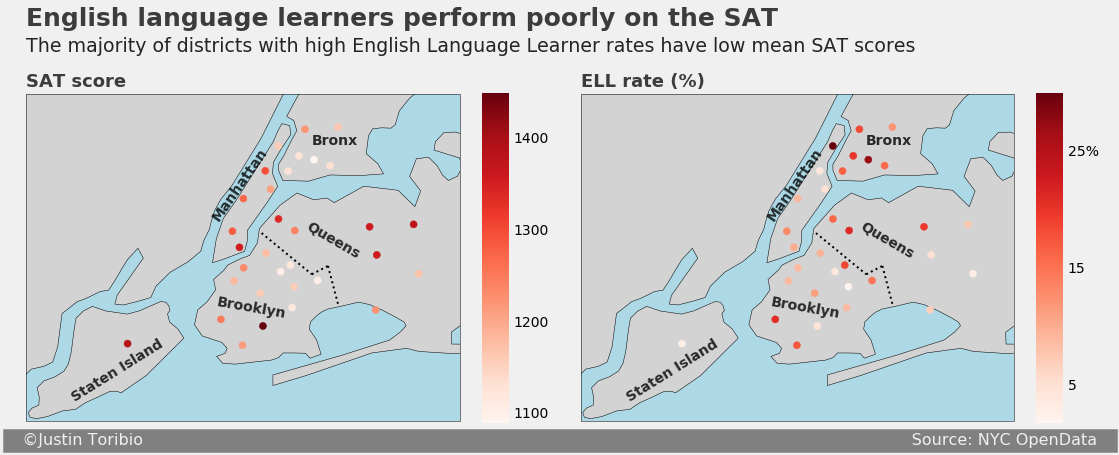

In [19]:
# Assign the title and subtitle of the map plot to variables.
title = "English language learners perform poorly on the SAT"
subtitle = ("The majority of districts with high English Language Learner" 
            " rates have low mean SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "ell_percent", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT score", 
               map_title_2="ELL rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[5, 15, 25], 
               colorbar_tick_labels_2=[5, 15, "25%"])

The majority of school districts with high ELL rates have low mean SAT scores.  Again, this is a reasonably intuitive expectation since the SAT is written in English.  

Next, we will compare the map of Hispanic student %'s with the map of English Language Learner rates.

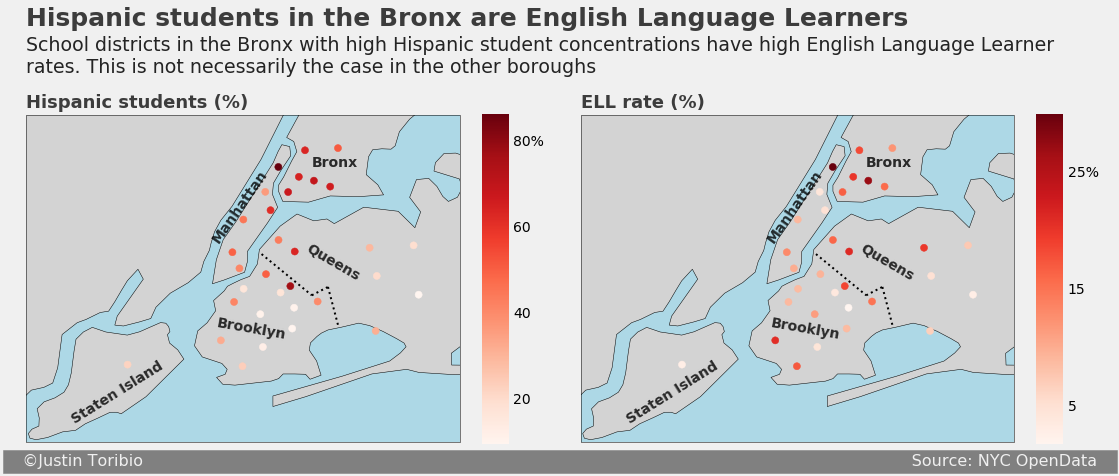

In [20]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students in the Bronx are English Language Learners"
subtitle = ("School districts in the Bronx with high Hispanic student"
            " concentrations have high English Language Learner\n"
            "rates. This is not necessarily the case in the other boroughs")

# Create and display the side by side map plot.
create_nyc_map("hispanic_per", "ell_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Hispanic students (%)", 
               map_title_2="ELL rate (%)",
               colorbar_ticks_1=[20, 40, 60, 80],
               colorbar_tick_labels_1=[20, 40, 60, "80%"], 
               colorbar_ticks_2=[5, 15, 25], 
               colorbar_tick_labels_2=[5, 15, "25%"])

The majority of districts with high Hispanic student %'s have high ELL rates.  This is particularly true in the Bronx, which we already know has a population with a Hispanic majority.  This is a reasonably intuitive expectation as many of the Hispanic residents could be immigrants that speak Spanish as their primary language.

This is not necessarily the case in the other boroughs.  A few districts in Manhattan have high Hispanic student concentrations but low ELL rates.  

All of the above findings suggest that the relationships we have observed between SAT scores and White, Asian and Hispanic students have more to do with whether those students come from low-income families and if they are learning English, rather than any type of inherent racial bias in the SAT.  

# Exploring class size data and SAT scores  

The 12th and 13th column names in the initial correlation bar plot above (`"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"`) both pertain to class size data.  We will display the bar plot again showing only these columns.

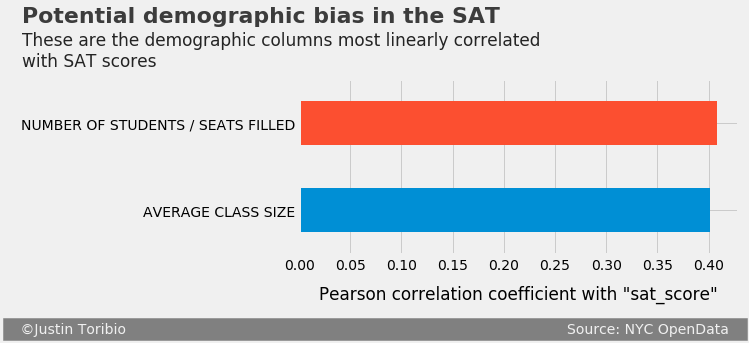

In [21]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["AVERAGE CLASS SIZE", "NUMBER OF STUDENTS / SEATS FILLED"]
title = "Potential demographic bias in the SAT"
subtitle = ("These are the demographic columns most linearly correlated\n"
            "with SAT scores")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.85, title_x_adj=-.271,
              sub=subtitle, sub_y_adj=-1.35, sub_x_adj=-.271,
              sig_y_adj=2.6, sig_x_adj=-.285, sig_space_adj=96)

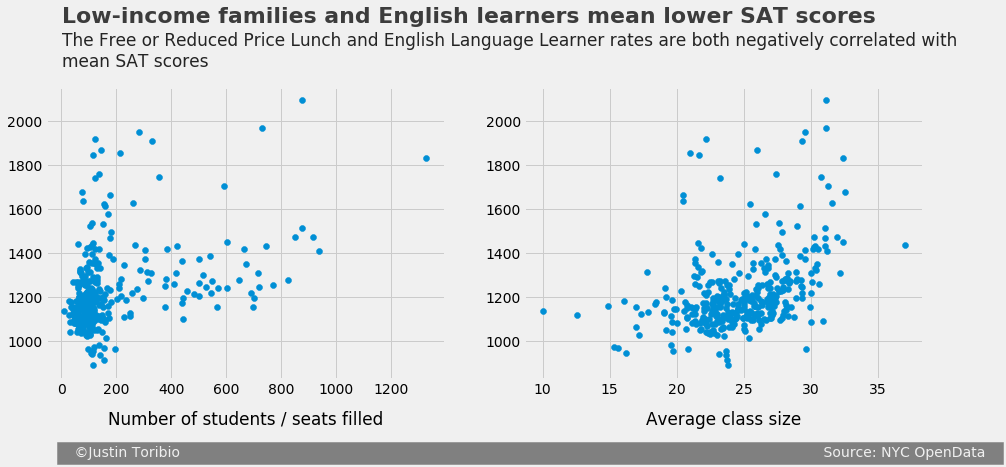

In [22]:
# Assign the text of the scatter plots to variables.
title = "Low-income families and English learners mean lower SAT scores"
subtitle = ("The Free or Reduced Price Lunch and English Language Learner"
            " rates are both negatively correlated with\n"
            "mean SAT scores")
x_axis_label_1 = "Number of students / seats filled"
x_axis_label_2 = "Average class size"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["NUMBER OF STUDENTS / SEATS FILLED"], data["sat_score"])
#ax1.set_xticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=3, y=2450, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=3, y=2250, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-1, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["AVERAGE CLASS SIZE"], data["sat_score"])
#ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

A possible explanation is that larger student populations and average class sizes means the schools have adequate funding to provide the academic resources (i.e. teachers, classrooms, buildings etc...) necessary to support such large student bodies.  This would imply that schools with larger student populations and average class sizes are located in high-income neighborhoods.  

To test our hypothesis, we will look at the Pearson correlation coefficients between `"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"` and `"sat_score"`.

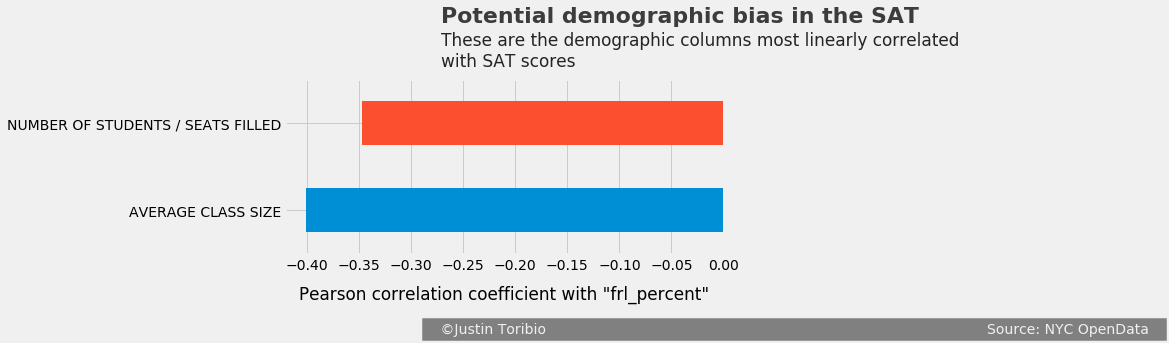

In [23]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["AVERAGE CLASS SIZE", "NUMBER OF STUDENTS / SEATS FILLED"]
title = "Potential demographic bias in the SAT"
subtitle = ("These are the demographic columns most linearly correlated\n"
            "with SAT scores")
x_axis_label = 'Pearson correlation coefficient with "frl_percent"'

# Create and display the bar plot.
corr_bar_plot(data, "frl_percent", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.85, title_x_adj=-.271,
              sub=subtitle, sub_y_adj=-1.35, sub_x_adj=-.271,
              sig_y_adj=2.6, sig_x_adj=-.285, sig_space_adj=96)

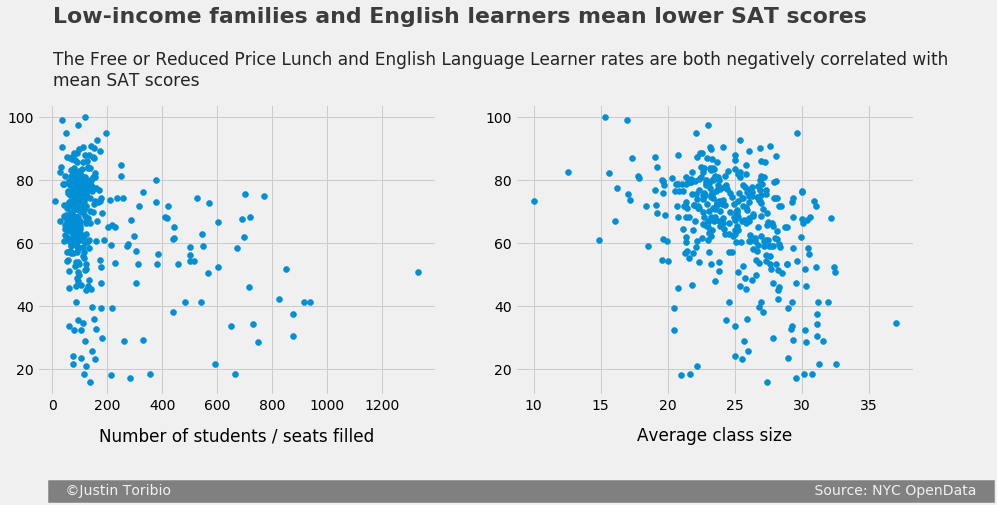

In [24]:
# Assign the text of the scatter plots to variables.
title = "Low-income families and English learners mean lower SAT scores"
subtitle = ("The Free or Reduced Price Lunch and English Language Learner"
            " rates are both negatively correlated with\n"
            "mean SAT scores")
x_axis_label_1 = "Number of students / seats filled"
x_axis_label_2 = "Average class size"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["NUMBER OF STUDENTS / SEATS FILLED"], data["frl_percent"])
#ax1.set_xticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=3, y=130, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=3, y=110, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-1, y=-20, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["AVERAGE CLASS SIZE"], data["frl_percent"])
#ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

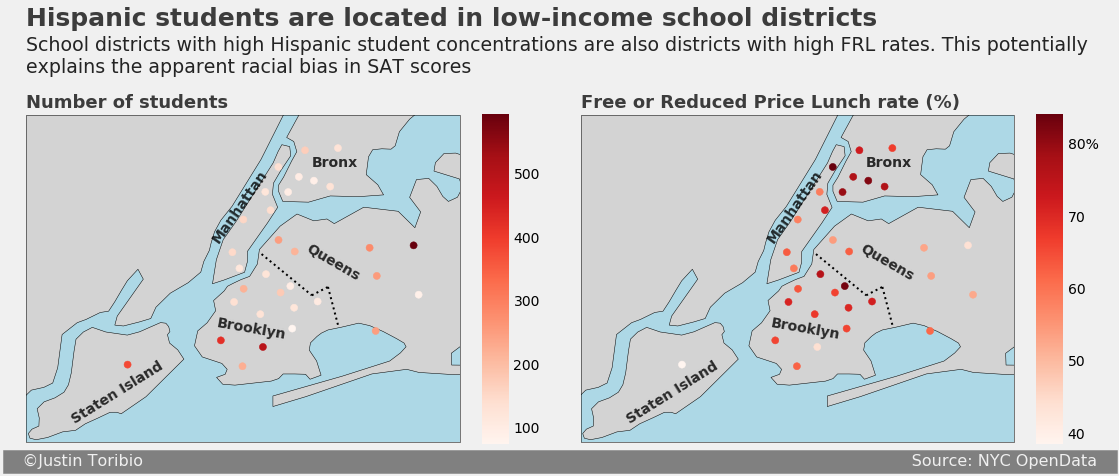

In [25]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students are located in low-income school districts"
subtitle = ("School districts with high Hispanic student concentrations are" 
            " also districts with high FRL rates. This potentially\n"
            "explains the apparent racial bias in SAT scores")

# Create and display the side by side map plot.
create_nyc_map("NUMBER OF STUDENTS / SEATS FILLED", "frl_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Number of students", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               #colorbar_ticks_1=[20, 40, 60, 80],
               #colorbar_tick_labels_1=[20, 40, 60, "80%"],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

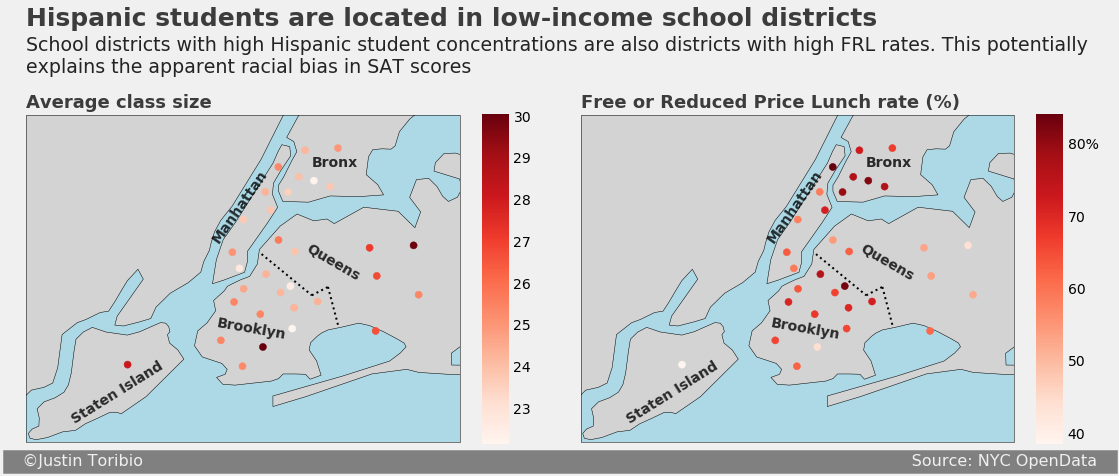

In [26]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students are located in low-income school districts"
subtitle = ("School districts with high Hispanic student concentrations are" 
            " also districts with high FRL rates. This potentially\n"
            "explains the apparent racial bias in SAT scores")

# Create and display the side by side map plot.
create_nyc_map("AVERAGE CLASS SIZE", "frl_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Average class size", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               #colorbar_ticks_1=[20, 40, 60, 80],
               #colorbar_tick_labels_1=[20, 40, 60, "80%"],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

All of this provides more evidence that the economic standing of the student's family and neighborhood is the biggest driver of SAT performance.

### AP data columns  

The 14th through 16th column names in the bar plot above (`"Num of AP Exams Passed"` to `"Num of AP Test Takers"`) all pertain to AP (advanced placement) results data.  There is not much insight to be gained from these columns, which represent the number of AP exams passed or taken and are all positively correlated with `"sat_score"`.  

AP exams are optional exams students can take to earn college credit in a particular subject.  It is a reasonably intuitive expectation that a high number of students being proactive to earn college credit in advance would correlate with high SAT scores.  Therefore, we will not explore any of these columns further.

### Graduation data columns  

The last 13 column names in the bar plot above (`"Dropped Out - % of cohort"` to `"Total Grads - n"`) all pertain to graduation data.  There is not much insight to be gained from any of these columns either.  

There are three different categories of high school diplomas offered to graduating students in New York State: a regular diploma called the Regents, the Regents Diploma with Advanced Designation, and the Local Diploma.  A Local Diploma is an option for students who can't get above a score of 65 on all of their Regents Exams, but can get above at least a 45.  A Regents Diploma with Advanced Designation is more difficult to earn than a regular Regents Diploma.

The first 5 column names in this group (`"Dropped Out - % of cohort"` to `"Regents w/o Advanced - % of grads"`) are all negatively correlated with SAT scores.  These columns represent the percent of cohorts/graduates who either dropped out, are still enrolled, or received a Local or regular Regents diploma.  It is a reasonably intuitive expectation that high values in these columns would correlate with low SAT scores.  Therefore, we will not explore any of these columns further.  

The last 8 column names in this group (`"Advanced Regents - % of grads"` to `"Total Grads - n"`) are all positively correlated with SAT scores.  These columns represent the number/percent of cohorts/graduates who either received an Advanced Regents diploma, any kind of Regents diploma (so NOT a local diploma), or graduated.  It is a reasonably intuitive expectation that high values in these columns would correlate with high SAT scores.  Therefore, we will not explore any of these columns further.  

 
Finally, we will view the horizontal bar plot again with only the final selected columns.

# Probably delete this

In [ ]:
# Drop the columns to be removed from the dataset.
filtered_correlations.drop(["Num of AP Total Exams Taken",
                            "Num of AP Exams Passed",
                            "Total Grads - % of cohort",
                            "Total Regents - n",
                            "Total Regents - % of cohort",
                            "Total Regents - % of grads",
                            "Advanced Regents - n",
                            "Advanced Regents - % of grads",
                            "Local - % of cohort",
                            "Local - % of grads",
                            "Still Enrolled - % of cohort"], inplace=True)

# Assign the text of the bar plot to variables.
title = "Potential sources of bias to explore further"
subtitle = ("These are the data columns we will explore to uncover any\n"
            "potential bias in the SAT")
x_axis_label = 'Correlation coefficient with "sat_score"'
signature = (
    "   ©Justin Toribio                                               "
    "                                         Source: NYC OpenData   "
)

# Create the bar plot, add the text and display the plot.
plt.close("all")
style.use("fivethirtyeight")
graph = filtered_correlations.plot.barh(figsize=(7, 5))
graph.set_xlabel(x_axis_label, labelpad=13)
graph.text(s=title, x=-1.7, y=5.55, fontsize=26, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-1.7, y=4.75, fontsize=20, alpha=.85)
graph.text(s=signature, x=-1.75, y=-2, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

# (delete this entire section??) Exploring graduation data and SAT scores  

There are three different categories of high school diplomas offered to graduating students in New York State: a regular diploma called the Regents, the Regents Diploma with Advanced Designation, and the Local Diploma.  A Regents Diploma is earned upon successful completion of the Regents Exams, which are statewide standardized examinations in the required subjects.  A Local Diploma is an option for students who can't get above a score of 65 on all of their Regents Exams, but can get above at least a 45.

### Passing the Advanced Regents correlates with higher SAT scores

Earning a Regents Diploma with Advanced Designation requires passing a more rigorous battery of Regents Exams (herein referred to as the "Advanced Regents") than earning a regular Regents Diploma.  The `"Advanced Regents - % of cohort"` column in `data` represents the percentage of total Cohorts (students in the same graduating year) that passed the Advanced Regents, by school.  

We will create a scatter plot of the data, with Advanced Regents pass rates on the x-axis and mean SAT scores on the y-axis.  Each dot on the scatter plot represents a different school.  This will give us a good visual representation of the linear relationship between the two variables. 

In [ ]:
# Assign the text of the scatter plot to variables.
title = ("Passing the Advanced Regents\n"
         "correlates with higher SAT scores")
subtitle = ("The Advanced Regents pass rate has a strong positive\n"
            "correlation with mean SAT score")
x_axis_label = "Advanced Regents pass rate (%)"
signature = ("   ©Justin Toribio                              "
             "                  Source: NYC OpenData   ")

# Create the scatter plot, add the text and display the plot.
plt.close("all")
style.use("fivethirtyeight")
graph = data.plot.scatter(x="Advanced Regents - % of cohort", y="sat_score",
                          figsize=(7, 5))
graph.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
graph.set_xlabel(x_axis_label, labelpad=14)
graph.yaxis.label.set_visible(False)
graph.text(s=title, x=-15, y=2375, fontsize=22, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-15, y=2200, fontsize=16, alpha=.85)
graph.text(s=signature, x=-18, y=470, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

Schools that have a higher Advanced Regents pass rate also tend to have higher mean SAT scores (the correlation coefficient between the two variables is approximately 0.8).  All schools that have an Advanced Regents pass rate above 30% have a mean SAT score of at least 1200.  In contrast, there are some schools that have mean SAT scores around 1700 and above that have 0% Advanced Regents pass rates.  

This suggests a school can have high SAT scores while not necessarily having a high pass rate on the Advanced Regents.  Perhaps the school has a lot of high-performing students that decide not to pursue the Regents Diploma with Advanced Designation, or the Advanced Regents Exams are more difficult than the SAT.

However, it is unlikely that a school with a high Advanced Regents pass rate will have low SAT scores.  This is an intuitive expectation: a large proportion of students passing the challenging Advanced Regents Exams would be expected to perform well on the SAT as well.  The Advanced Regents Exams possibly being more difficult than the SAT could also be an explanation.  

### Advanced Regents pass rates mirror SAT scores geographically  

Next, we will create another map of the school districts by their Advanced Regents pass rates and compare it to the map of SAT scores.  This will let us compare the geographic patterns between the 2 variables.

We will create and display the 2 maps side by side using the `create_nyc_map` function.

In [ ]:
# Assign the title and subtitle of the map plot to variables.
title = "Advanced Regents pass rates mirror SAT scores geographically"
subtitle = ("The geographic pattern of Advanced Regents pass rates is almost" 
            " identical to SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "Advanced Regents - % of cohort", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT scores", 
               map_title_2="Advanced Regents pass rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[10, 20, 30, 40], 
               colorbar_tick_labels_2=[10, 20, 30, "40%"])

The geographic pattern of Advanced Regents pass rates (right map) looks almost identical to the pattern of SAT scores (left map).  Like SAT scores, the school districts with the lowest Advanced Regents pass rates are in Brooklyn and the Bronx, while none in Manhattan, Queens or Staten Island are at the extreme low end (nearly white dots).

Every district that has a high Advanced Regents pass rate also has high SAT scores.  In contrast, the majority of Manhattan's school districts are on the low end of the range of Advanced Regents pass rates (10-20%), while still having SAT scores on the mid to high end of the range.  This is consistent with our findings when we looked at the correlation scatter plot above: high Advanced Regents pass rates will almost always coincide with high SAT scores, but not necessarily the other way around.  

All of this leads to the question: **why do schools in Brooklyn and the Bronx perform less well academically compared to schools in the other boroughs?**  We will try to answer this question in the rest of this project.

# Demographic data and SAT scores

In [ ]:
# Assign the text of the scatter plot to variables.
title = ("Passing the Advanced Regents\n"
         "correlates with higher SAT scores")
subtitle = ("The Advanced Regents pass rate has a strong positive\n"
            "correlation with mean SAT score")
x_axis_label = "Free lunch rate (%)"
signature = ("   ©Justin Toribio                              "
             "                  Source: NYC OpenData   ")

# Create the scatter plot, add the text and display the plot.
plt.close("all")
style.use("fivethirtyeight")
graph = data.plot.scatter(x="frl_percent", y="sat_score",
                          figsize=(7, 5))
#graph.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
graph.set_xlabel(x_axis_label, labelpad=14)
graph.yaxis.label.set_visible(False)
graph.text(s=title, x=-15, y=2375, fontsize=22, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-15, y=2200, fontsize=16, alpha=.85)
graph.text(s=signature, x=-18, y=470, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

In [ ]:
# Assign the title and subtitle of the map plot to variables.
title = "Advanced Regents pass rates mirror SAT scores geographically"
subtitle = ("The geographic pattern of Advanced Regents pass rates is almost" 
            " identical to SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "frl_percent", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               map_title_1="SAT scores", 
               map_title_2="Free lunch rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               #colorbar_ticks_2=[10, 20, 30, 40], 
               #colorbar_tick_labels_2=[10, 20, 30, "40%"])
              )

# Plotting language learning percentage

In [ ]:
data.plot(x="ell_percent", y="sat_score", kind="scatter")
correlations["ell_percent"]

# Mapping the schools

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

fig = plt.figure(figsize=(7,7))

# make this subplot a little bit wider somehow??? Or figure out how to change cartopy subplot bg color
ax1 = fig.add_subplot(111)
ax1.set_facecolor("lightblue")
ax1.tick_params(
    axis='both', which='both', bottom=False,
    top=False, left=False, right=False,
    labelleft=False, labelbottom=False
    )

ax2 = fig.add_subplot(111, projection=ccrs.Mercator())
ax2.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax2.background_patch.set_fill(False)
ax2.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = data["lon"].tolist()
latitudes = data["lat"].tolist()

ax.scatter(longitudes, latitudes, transform=ccrs.PlateCarree(), s=20, zorder=4)

# Plotting out statistics

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

ax.scatter(longitudes, latitudes, s=20, zorder=2, c=data["ell_percent"], cmap="summer")

# Calculating district level statistics

In [ ]:
import numpy as np

districts = data.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head()

# Plotting "percent of English learners" by district

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["ell_percent"], cmap="summer")

# Correlation between survey results and SAT scores

In [ ]:
survey_fields_with_SAT = [
    "DBN",
    "sat_score",
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    ]

corr_survey_sat = data.loc[:, survey_fields_with_SAT].corr()
corr_survey_sat = corr_survey_sat["sat_score"][1:]

corr_survey_sat.plot.barh()

Mine: Academic expectations and safety and respect scores have strong r-values with SAT scores. Makes sense, hard to learn in an unsafe environment, and I'd expect high achieving students with high expectations of a school to perform well academically at that school.

Solution: There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers perceived safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety and SAT scores

In [ ]:
data.plot.scatter(x="saf_s_11", y="sat_score")

Mine: Doesn't appear to be a strong linear correlations, weak at best.

Solution: There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["saf_s_11"], cmap="summer")

Mine: Safest schools are in Manhattan as expected. With exception of a few, the least safe schools are in Brooklyn, Queens and the Bronx

Solution: It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Exploring race and SAT scores

In [ ]:
race_cols = ["sat_score", "white_per", "asian_per", "black_per", "hispanic_per"]
race_sat = data[race_cols].corr()["sat_score"][1:]
race_sat.plot.barh()

Mine: Asian and White are strongly positively correlated. Hispanic and Black are strongly negatively correlated.  Possibly suggests racial bias in test, or indicative of lack of funding for schools in areas with high % of hispanic and black students.

Solution: It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

In [ ]:
data.plot.scatter("hispanic_per", "sat_score")

Mine: appears to be negative correlation, although not that strong. Schools with greater than approx 25% Hispanic don't have an SAT score above around 1500

In [ ]:
data[data["hispanic_per"] > 95]["SCHOOL NAME"]

Solution: The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [ ]:
hisp_10_1800 = data[data["hispanic_per"] < 10]
hisp_10_1800[hisp_10_1800["sat_score"] > 1800]["SCHOOL NAME"]

Mine: all appear to be science and technical schools, suggesting higher acceptance requirements, and hence higher achieving students

Solution: Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring gender and SAT scores

In [ ]:
sex_cols = ["sat_score", "male_per", "female_per"]
sex_sat = data[sex_cols].corr()["sat_score"][1:]
sex_sat.plot.barh()

Mine: females positive corr, males negative corr, but neither are strong.

Solution: In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

In [ ]:
data.plot.scatter("female_per", "sat_score")

Mine: don't see any strong linear corr.  There's high and low sat scores with high and low female_per

Solution: Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [ ]:
fem_60_1700 = data[data["female_per"] > 60]
fem_60_1700[fem_60_1700["sat_score"] > 1700]["SCHOOL NAME"]

Solution: These schools appears to be very selective liberal arts schools that have high academic standards

# Exploring AP scores vs SAT scores

In [ ]:
data["ap_per"] = data["Num of AP Test Takers"] / data["total_enrollment"]
data.plot.scatter("ap_per", "sat_score")

Mine: some corr but not strong. There is a cluster of schools with ap_per > .4 with high SAT, but also a bunch with very high ap_per with SAT no greater than 1200

Solution: It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion  

There could be more to the story and I encourage anyone to expand upon this project.